In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Nguyễn Việt Quang B22DCCN650
# Load CSV
df = pd.read_csv("diabetes.csv")
# print(df.head())

# Thống kê số giá trị NaN
# Nguyen Việt Quang B22DCCN650
# nan_counts = df.isna().sum()
# print("Số giá trị NaN trong từng cột:")
# print(nan_counts)

# Thống kê số giá trị bằng 0
# Nguyen Việt Quang B22DCCN650
# zero_counts = (df == 0).sum()
# print("\nSố giá trị bằng 0 trong từng cột:")
# print(zero_counts)

# Thay thế giá trị 0 bằng giá trị trung vị của cột tương ứng
# Nguyen Việt Quang B22DCCN650
cols_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for c in cols_with_zero:
    df[c] = df[c].replace(0, df[c].median())

# Thống ket lại số giá trị bằng 0 sau khi thay thế
# Nguyen Việt Quang B22DCCN650
# zero_counts_after = (df == 0).sum()
# print("\nSố giá trị bằng 0 trong từng cột sau khi thay thế:")
# print(zero_counts_after)

# Thống kê số lượng và tỷ lệ phần trăm từng class trong cột 'Outcome'
# Nguyen Việt Quang B22DCCN650
class_counts = df['Outcome'].value_counts()
class_percent = df['Outcome'].value_counts(normalize=True) * 100  # chuyển sang %
print("Số lượng từng class:")
print(class_counts)
print("\nTỷ lệ phần trăm từng class:")
print(class_percent)

# Tách features và target
# Nguyen Việt Quang B22DCCN650
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Chuẩn hóa dữ liệu
# Nguyen Việt Quang B22DCCN650
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import joblib
SCALER_DUMP_PATH = "scaler_diabetes.joblib" # Đặt tên file đúng như bạn muốn dùng trong Flask
joblib.dump(scaler, SCALER_DUMP_PATH)
print(f"StandardScaler đã được lưu vào: {SCALER_DUMP_PATH}")
# ----------------------------------------------------
# Chia dữ liệu thành tập huấn luyện, tập validation và tập test
# Nguyen Việt Quang B22DCCN650
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Chuyển đổi dữ liệu thành tf.data.Dataset
# Nguyen Việt Quang B22DCCN650
# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))



# train_ds = train_ds.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
# test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Xác định kích thước input cho mô hình
# Nguyen Việt Quang B22DCCN650
input_shape = (X_train.shape[1],)  # e.g. (8,)

import tensorflow.keras as keras
tf.config.run_functions_eagerly(True)
from tensorflow.keras import layers
# Model A: Sequential MLP (7 dense layers)
# Nguyen Việt Quang B22DCCN650
def build_model_A(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')   # output probability
    ], name="MLP_7layers")
    return model

# Model B: Deeper with BatchNorm + Dropout (9 layers)
# Nguyen Việt Quang B22DCCN650
def build_model_B(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(256)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="Deep_BN_Dropout")
    return model

# Model C: Functional with a residual-like skip (>=7 layers)
# Nguyen Việt Quang B22DCCN650
def build_model_C(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    skip = layers.Dense(128)(inputs)  # project input to match dims
    x = layers.Add()([x, skip])
    x = layers.Activation('relu')(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="Functional_Residual")
    return model

# Tạo các mô hình
# Nguyen Việt Quang B22DCCN650
models = {
    "A_MLP_7": build_model_A(input_shape),
    "B_Deep_BN_DO": build_model_B(input_shape),
    "C_Functional_Res": build_model_C(input_shape)
}

# ---------- Compile settings ----------
# Nguyen Việt Quang B22DCCN650
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = 'binary_crossentropy'
metrics = ['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]

for name, m in models.items():
    opt = keras.optimizers.Adam(learning_rate=1e-3)  # new optimizer for each model
    m.compile(optimizer=opt, loss=loss, metrics=metrics)
    # print(name, "summary:")
    m.summary()

# ---------- Callbacks ----------
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks_common = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)
]

# lưu model tốt nhất dựa trên val_loss
# Nguyen Việt Quang B22DCCN650
checkpoint_paths = {name: f"./best_{name}.h5" for name in models.keys()}


# ----------------- Training loop -----------------
histories = {}
results = {}
EPOCHS = 15
batch_size = 32

for name, model in models.items():
    print(f"\n--- Training model {name} ---")
    cp = ModelCheckpoint(checkpoint_paths[name], monitor='val_loss', save_best_only=True, verbose=1)
    cb = callbacks_common + [cp]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=batch_size,
        callbacks=cb,
        verbose=1
    )
    histories[name] = history

    # Load best weights
    model.load_weights(checkpoint_paths[name])

    # Predict probabilities
    val_probs = model.predict(X_val).ravel()
    test_probs = model.predict(X_test).ravel()

    # Predict classes
    val_preds = (val_probs >= 0.5).astype(int)
    test_preds = (test_probs >= 0.5).astype(int)

    # Metrics for classification
    val_acc = accuracy_score(y_val, val_preds)
    test_acc = accuracy_score(y_test, test_preds)
    val_prec = precision_score(y_val, val_preds, zero_division=0)
    test_prec = precision_score(y_test, test_preds, zero_division=0)
    val_rec = recall_score(y_val, val_preds, zero_division=0)
    test_rec = recall_score(y_test, test_preds, zero_division=0)

    # Metrics for regression (on probabilities)
    val_mae = mean_absolute_error(y_val, val_probs)
    test_mae = mean_absolute_error(y_test, test_probs)
    val_mse = mean_squared_error(y_val, val_probs)
    test_mse = mean_squared_error(y_test, test_probs)
    val_rmse = np.sqrt(val_mse)
    test_rmse = np.sqrt(test_mse)

    results[name] = {
        'val_acc': val_acc, 'test_acc': test_acc,
        'val_precision': val_prec, 'test_precision': test_prec,
        'val_recall': val_rec, 'test_recall': test_rec,
        'val_mae': val_mae, 'test_mae': test_mae,
        'val_mse': val_mse, 'test_mse': test_mse,
        'val_rmse': val_rmse, 'test_rmse': test_rmse
    }

    print(f"Results for {name}: val_rmse={val_rmse:.4f}, test_rmse={test_rmse:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")
    import matplotlib.pyplot as plt

# --- Plot Training History ---
plt.figure(figsize=(16, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title("Precision over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title("Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()

plt.tight_layout()
plt.show()



Số lượng từng class:
Outcome
0    500
1    268
Name: count, dtype: int64

Tỷ lệ phần trăm từng class:
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64
StandardScaler đã được lưu vào: scaler_diabetes.joblib


Model: "MLP_7layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,321 (63.75 KB)

 Trainable params: 16,321 (63.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Deep_BN_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,873 (187.00 KB)

 Trainable params: 46,977 (183.50 KB)

 Non-trainable params: 896 (3.50 KB)

Model: "Functional_Residual"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │      1,152 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     16,512 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │      1,152 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ dense_14[0][0],   │
│                     │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │      2,080 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 16)        │        528 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         17 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,697 (116.00 KB)

 Trainable params: 29,697 (116.00 KB)

 Non-trainable params: 0 (0.00 B)


--- Training model A_MLP_7 ---


D:\school\se1_year4\IntSys\tieu_luan\code\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6575 - loss: 0.6603 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_loss improved from None to 0.56706, saving model to ./best_A_MLP_7.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.6480 - loss: 0.6354 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6783 - val_loss: 0.5671 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6457 - loss: 0.5511 - precision: 0.4243 - recall: 0.0274
Epoch 2: val_loss improved from 0.56706 to 0.51758, saving model to ./best_A_MLP_7.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.6797 - loss: 0.5232 - precision: 0.8077 - recall: 0.1117 - val_accuracy: 0.7304 - val_loss: 0.5176 - val_precision: 0.6154 - val_recall: 0.4324 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7832 - loss: 0.4780 - precision: 0.7463 - recall: 0.5644
Epoch 3: val_loss improved from 0.51758 to 0.50926, saving model to ./best_A_MLP_7.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.7654 - loss: 0.4771 - precision: 0.6890 - recall: 0.6011 - val_accuracy: 0.7391 - val_loss: 0.5093 - val_precision: 0.5946 - val_recall: 0.5946 - learning_rate: 0.0010
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7962 - loss: 0.4540 - precision: 0.7228 - recall: 0.6983
Epoch 4: val_loss improved from 0.50926 to 0.50208, saving model to ./best_A_MLP_7.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.7914 - loss: 0.4498 - precision: 0.7111 - recall: 0.6809 - val_accuracy: 0.7130 - val_loss: 0.5021 - val_precision: 0.5435 - val_recall: 0.6757 - learning_rate: 0.0010
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7706 - loss: 0.4479 - precision: 0.6774 - recall: 0.7579
Epoch 5: val_loss did not improve from 0.50208
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.7952 - loss: 0.4250 - precision: 0.6912 - recall: 0.7500 - val_accuracy: 0.7217 - val_loss: 0.5244 - val_precision: 0.5641 - val_recall: 0.5946 - learning_rate: 0.0010
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7809 - loss: 0.4290 - precision: 0.6890 - recall: 0.6888
Epoch 6: val_loss did not improve from 0.50208
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.7914 - loss: 0.4123 - precision: 0.6959 - recall: 0.7181 - val_accuracy: 0.7391 - val_loss: 0.5172 - val_precision: 0.5854 - val_recall: 0.6486 - learning_rate

D:\school\se1_year4\IntSys\tieu_luan\code\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6582 - loss: 0.6646 - precision: 0.5702 - recall: 0.4616
Epoch 1: val_loss improved from None to 0.62318, saving model to ./best_B_Deep_BN_DO.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.6797 - loss: 0.6011 - precision: 0.5823 - recall: 0.4089 - val_accuracy: 0.7043 - val_loss: 0.6232 - val_precision: 0.5385 - val_recall: 0.5676 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7379 - loss: 0.4963 - precision: 0.6569 - recall: 0.4818
Epoch 2: val_loss improved from 0.62318 to 0.57719, saving model to ./best_B_Deep_BN_DO.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.7542 - loss: 0.4791 - precision: 0.7029 - recall: 0.5160 - val_accuracy: 0.7391 - val_loss: 0.5772 - val_precision: 0.6000 - val_recall: 0.5676 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7831 - loss: 0.4631 - precision: 0.6936 - recall: 0.6414
Epoch 3: val_loss improved from 0.57719 to 0.54562, saving model to ./best_B_Deep_BN_DO.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.7970 - loss: 0.4403 - precision: 0.7365 - recall: 0.6543 - val_accuracy: 0.7391 - val_loss: 0.5456 - val_precision: 0.6207 - val_recall: 0.4865 - learning_rate: 0.0010
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7714 - loss: 0.4335 - precision: 0.6853 - recall: 0.6263
Epoch 4: val_loss improved from 0.54562 to 0.53769, saving model to ./best_B_Deep_BN_DO.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.7784 - loss: 0.4328 - precision: 0.7018 - recall: 0.6383 - val_accuracy: 0.7217 - val_loss: 0.5377 - val_precision: 0.5714 - val_recall: 0.5405 - learning_rate: 0.0010
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8161 - loss: 0.4089 - precision: 0.7447 - recall: 0.6813
Epoch 5: val_loss improved from 0.53769 to 0.53006, saving model to ./best_B_Deep_BN_DO.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.7989 - loss: 0.4194 - precision: 0.7469 - recall: 0.6436 - val_accuracy: 0.7304 - val_loss: 0.5301 - val_precision: 0.5938 - val_recall: 0.5135 - learning_rate: 0.0010
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8048 - loss: 0.3954 - precision: 0.7443 - recall: 0.6801
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_loss improved from 0.53006 to 0.52288, saving model to ./best_B_Deep_BN_DO.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.8045 - loss: 0.4017 - precision: 0.7427 - recall: 0.6755 - val_accuracy: 0.7304 - val_loss: 0.5229 - val_precision: 0.5938 - val_recall: 0.5135 - learning_rate: 0.0010
Epoch 7/15
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8025 - loss: 0.4169 - precision: 0.7517 - recall: 0.6354

KeyboardInterrupt: 

Số lượng từng class:
Outcome
0    500
1    268
Name: count, dtype: int64

Tỷ lệ phần trăm từng class:
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64
StandardScaler đã được lưu vào: scaler_diabetes.joblib


Model: "MLP_7layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,321 (63.75 KB)

 Trainable params: 16,321 (63.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "MLP_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


D:\school\se1_year4\IntSys\tieu_luan\code\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5975 - loss: 0.6830 - precision: 0.4424 - recall: 0.2671
Epoch 1: val_loss improved from None to 0.61358, saving model to ./best_model_A.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.6499 - loss: 0.6656 - precision: 0.5000 - recall: 0.1649 - val_accuracy: 0.6609 - val_loss: 0.6136 - val_precision: 0.2500 - val_recall: 0.0270
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6779 - loss: 0.5762 - precision: 0.9405 - recall: 0.0810
Epoch 2: val_loss improved from 0.61358 to 0.52835, saving model to ./best_model_A.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.6853 - loss: 0.5375 - precision: 0.8519 - recall: 0.1223 - val_accuracy: 0.7478 - val_loss: 0.5283 - val_precision: 0.6667 - val_recall: 0.4324
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7666 - loss: 0.5037 - precision: 0.7467 - recall: 0.5494
Epoch 3: val_loss did not improve from 0.52835
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7765 - loss: 0.4706 - precision: 0.7099 - recall: 0.6117 - val_accuracy: 0.7043 - val_loss: 0.5336 - val_precision: 0.5349 - val_recall: 0.6216
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7954 - loss: 0.4373 - precision: 0.7101 - recall: 0.6788
Epoch 4: val_loss did not improve from 0.52835
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.7896 - loss: 0.4397 - precision: 0.7095 - recall: 0.6755 - val_accuracy: 0.7304 - val_loss: 0.5288 - val_precision: 0.5714 - val_recall: 0.6486
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy:

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.8138 - loss: 0.3832 - precision: 0.7444 - recall: 0.7128 - val_accuracy: 0.7304 - val_loss: 0.5239 - val_precision: 0.5789 - val_recall: 0.5946
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8225 - loss: 0.3641 - precision: 0.7448 - recall: 0.7611
Epoch 8: val_loss did not improve from 0.52394
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.8175 - loss: 0.3674 - precision: 0.7446 - recall: 0.7287 - val_accuracy: 0.7478 - val_loss: 0.5500 - val_precision: 0.5870 - val_recall: 0.7297
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8432 - loss: 0.3450 - precision: 0.7783 - recall: 0.7897
Epoch 9: val_loss did not improve from 0.52394
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.8305 - loss: 0.3586 - precision: 0.7622 - recall: 0.7500 - val_accuracy: 0.7478 - val_loss: 0.5338 - val_precision: 0.5952 - val_recall: 0.6757
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.5363 - loss: 0.6907 - precision: 0.4051 - recall: 0.5600 - val_accuracy: 0.6696 - val_loss: 0.6500 - val_precision: 0.4444 - val_recall: 0.1081
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6577 - loss: 0.6439 - precision: 0.5713 - recall: 0.2999
Epoch 2: val_loss improved from 0.65004 to 0.60429, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.6704 - loss: 0.6352 - precision: 0.5618 - recall: 0.2660 - val_accuracy: 0.6870 - val_loss: 0.6043 - val_precision: 0.5714 - val_recall: 0.1081
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7166 - loss: 0.5870 - precision: 0.6210 - recall: 0.2527
Epoch 3: val_loss improved from 0.60429 to 0.56566, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.6741 - loss: 0.5968 - precision: 0.5915 - recall: 0.2234 - val_accuracy: 0.6870 - val_loss: 0.5657 - val_precision: 0.5455 - val_recall: 0.1622
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7097 - loss: 0.5562 - precision: 0.7292 - recall: 0.2865
Epoch 4: val_loss improved from 0.56566 to 0.53516, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7058 - loss: 0.5603 - precision: 0.7344 - recall: 0.2500 - val_accuracy: 0.7043 - val_loss: 0.5352 - val_precision: 0.5882 - val_recall: 0.2703
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7009 - loss: 0.5624 - precision: 0.6963 - recall: 0.4286
Epoch 5: val_loss improved from 0.53516 to 0.52159, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.7318 - loss: 0.5282 - precision: 0.6774 - recall: 0.4468 - val_accuracy: 0.7217 - val_loss: 0.5216 - val_precision: 0.5862 - val_recall: 0.4595
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7494 - loss: 0.5296 - precision: 0.6891 - recall: 0.5168
Epoch 6: val_loss improved from 0.52159 to 0.51194, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.7505 - loss: 0.5131 - precision: 0.6957 - recall: 0.5106 - val_accuracy: 0.7217 - val_loss: 0.5119 - val_precision: 0.5806 - val_recall: 0.4865
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7780 - loss: 0.4755 - precision: 0.7006 - recall: 0.5746
Epoch 7: val_loss improved from 0.51194 to 0.51011, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.7672 - loss: 0.4848 - precision: 0.7266 - recall: 0.5372 - val_accuracy: 0.7478 - val_loss: 0.5101 - val_precision: 0.6176 - val_recall: 0.5676
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7557 - loss: 0.4922 - precision: 0.7070 - recall: 0.6096
Epoch 8: val_loss did not improve from 0.51011
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7747 - loss: 0.4707 - precision: 0.7055 - recall: 0.6117 - val_accuracy: 0.7391 - val_loss: 0.5178 - val_precision: 0.5946 - val_recall: 0.5946
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7656 - loss: 0.4799 - precision: 0.7045 - recall: 0.6232
Epoch 9: val_loss did not improve from 0.51011
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7821 - loss: 0.4679 - precision: 0.7006 - recall: 0.6596 - val_accuracy: 0.7391 - val_loss: 0.5161 - val_precision: 0.6000 - val_recall: 0.5676
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7728 - loss: 0.4484 - precision: 0.6964 - recall: 0.6223 - val_accuracy: 0.7391 - val_loss: 0.5081 - val_precision: 0.6000 - val_recall: 0.5676
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7951 - loss: 0.4457 - precision: 0.7471 - recall: 0.6636
Epoch 11: val_loss did not improve from 0.50809
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7728 - loss: 0.4626 - precision: 0.6988 - recall: 0.6170 - val_accuracy: 0.7304 - val_loss: 0.5094 - val_precision: 0.5833 - val_recall: 0.5676
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7928 - loss: 0.4340 - precision: 0.6667 - recall: 0.6450
Epoch 12: val_loss improved from 0.50809 to 0.50731, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.7896 - loss: 0.4578 - precision: 0.7219 - recall: 0.6489 - val_accuracy: 0.7478 - val_loss: 0.5073 - val_precision: 0.6111 - val_recall: 0.5946
Epoch 13/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7755 - loss: 0.4719 - precision: 0.6942 - recall: 0.6514
Epoch 13: val_loss improved from 0.50731 to 0.50282, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7840 - loss: 0.4548 - precision: 0.7022 - recall: 0.6649 - val_accuracy: 0.7478 - val_loss: 0.5028 - val_precision: 0.6111 - val_recall: 0.5946
Epoch 14/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7862 - loss: 0.4342 - precision: 0.7278 - recall: 0.6508
Epoch 14: val_loss did not improve from 0.50282
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7803 - loss: 0.4510 - precision: 0.7059 - recall: 0.6383 - val_accuracy: 0.7478 - val_loss: 0.5032 - val_precision: 0.6111 - val_recall: 0.5946
Epoch 15/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8012 - loss: 0.4148 - precision: 0.7164 - recall: 0.6205
Epoch 15: val_loss did not improve from 0.50282
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.7970 - loss: 0.4351 - precision: 0.7337 - recall: 0.6596 - val_accuracy: 0.7478 - val_loss: 0.5085 - val_precision: 0.6111 - val_recall: 0.5946
Epoch 16/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accu

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.7933 - loss: 0.4502 - precision: 0.7175 - recall: 0.6755 - val_accuracy: 0.7478 - val_loss: 0.5014 - val_precision: 0.6111 - val_recall: 0.5946
Epoch 17/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7724 - loss: 0.4550 - precision: 0.7047 - recall: 0.6613
Epoch 17: val_loss improved from 0.50143 to 0.49038, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7896 - loss: 0.4289 - precision: 0.7246 - recall: 0.6436 - val_accuracy: 0.7565 - val_loss: 0.4904 - val_precision: 0.6286 - val_recall: 0.5946
Epoch 18/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7841 - loss: 0.4295 - precision: 0.6831 - recall: 0.6429
Epoch 18: val_loss improved from 0.49038 to 0.48990, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.7821 - loss: 0.4354 - precision: 0.7126 - recall: 0.6330 - val_accuracy: 0.7565 - val_loss: 0.4899 - val_precision: 0.6286 - val_recall: 0.5946
Epoch 19/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8211 - loss: 0.4085 - precision: 0.7805 - recall: 0.6464
Epoch 19: val_loss did not improve from 0.48990
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7952 - loss: 0.4341 - precision: 0.7407 - recall: 0.6383 - val_accuracy: 0.7478 - val_loss: 0.4967 - val_precision: 0.6111 - val_recall: 0.5946
Epoch 20/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7753 - loss: 0.4715 - precision: 0.6886 - recall: 0.7034
Epoch 20: val_loss improved from 0.48990 to 0.48970, saving model to ./best_model_B.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7803 - loss: 0.4493 - precision: 0.6882 - recall: 0.6809 - val_accuracy: 0.7478 - val_loss: 0.4897 - val_precision: 0.6111 - val_recall: 0.5946
Epoch 21/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7821 - loss: 0.4328 - precision: 0.7550 - recall: 0.5959
Epoch 21: val_loss did not improve from 0.48970
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.7784 - loss: 0.4326 - precision: 0.7143 - recall: 0.6117 - val_accuracy: 0.7478 - val_loss: 0.4961 - val_precision: 0.6111 - val_recall: 0.5946
Epoch 22/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8106 - loss: 0.4062 - precision: 0.7325 - recall: 0.6879
Epoch 22: val_loss did not improve from 0.48970
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7914 - loss: 0.4220 - precision: 0.7159 - recall: 0.6702 - val_accuracy: 0.7478 - val_loss: 0.4943 - val_precision: 0.6111 - val_recall: 0.5946
Epoch 23/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accu

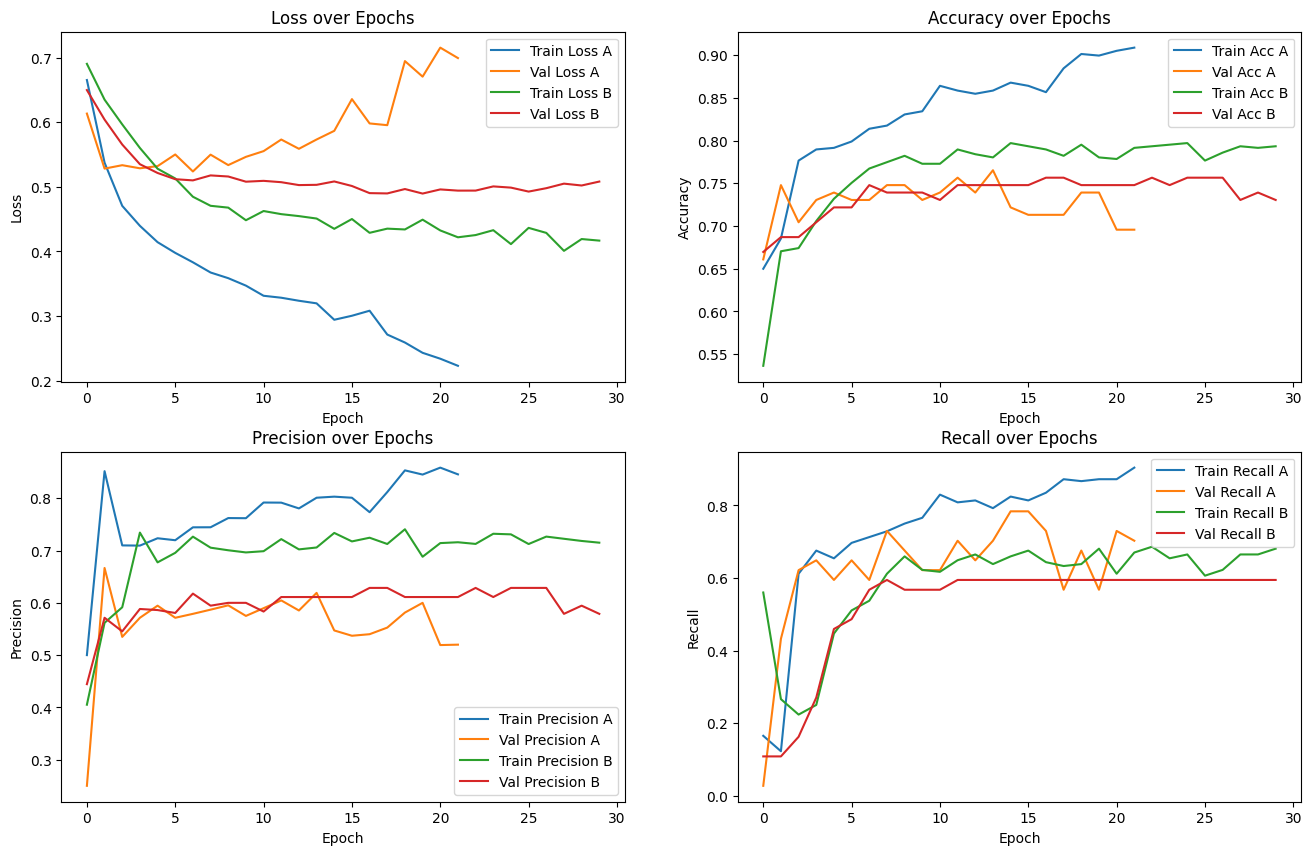

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Nguyễn Việt Quang B22DCCN650
# Load CSV
df = pd.read_csv("diabetes.csv")
# print(df.head())

# Thống kê số giá trị NaN
# Nguyen Việt Quang B22DCCN650
# nan_counts = df.isna().sum()
# print("Số giá trị NaN trong từng cột:")
# print(nan_counts)

# Thống kê số giá trị bằng 0
# Nguyen Việt Quang B22DCCN650
# zero_counts = (df == 0).sum()
# print("\nSố giá trị bằng 0 trong từng cột:")
# print(zero_counts)

# Thay thế giá trị 0 bằng giá trị trung vị của cột tương ứng
# Nguyen Việt Quang B22DCCN650
cols_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for c in cols_with_zero:
    df[c] = df[c].replace(0, df[c].median())

# Thống ket lại số giá trị bằng 0 sau khi thay thế
# Nguyen Việt Quang B22DCCN650
# zero_counts_after = (df == 0).sum()
# print("\nSố giá trị bằng 0 trong từng cột sau khi thay thế:")
# print(zero_counts_after)

# Thống kê số lượng và tỷ lệ phần trăm từng class trong cột 'Outcome'
# Nguyen Việt Quang B22DCCN650
class_counts = df['Outcome'].value_counts()
class_percent = df['Outcome'].value_counts(normalize=True) * 100  # chuyển sang %
print("Số lượng từng class:")
print(class_counts)
print("\nTỷ lệ phần trăm từng class:")
print(class_percent)

# Tách features và target
# Nguyen Việt Quang B22DCCN650
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Chuẩn hóa dữ liệu
# Nguyen Việt Quang B22DCCN650
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import joblib
SCALER_DUMP_PATH = "scaler_diabetes.joblib" # Đặt tên file đúng như bạn muốn dùng trong Flask
joblib.dump(scaler, SCALER_DUMP_PATH)
print(f"StandardScaler đã được lưu vào: {SCALER_DUMP_PATH}")
# ----------------------------------------------------

# Chia dữ liệu thành tập huấn luyện, tập validation và tập test
# Nguyen Việt Quang B22DCCN650
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# ---------- Build Model A ----------
def build_model_A(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')   # output probability
    ], name="MLP_7layers")
    return model

def build_model_B(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ], name="MLP_dropout")

    return model

input_shape = (X_train.shape[1],)  # e.g. (8,)

model_A = build_model_A(input_shape)
model_A.summary()
model_B = build_model_B(input_shape)
model_B.summary()

# ---------- Compile ----------
# model A
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = 'binary_crossentropy'
metrics = ['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
model_A.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# model B
optimizer_B = keras.optimizers.Adam(learning_rate=1e-3)
model_B.compile(optimizer=optimizer_B, loss=loss, metrics=metrics)



# ---------- Callbacks ----------
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint("./best_model_A.h5", monitor='val_loss', save_best_only=True, verbose=1)
]
callbacks_B = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint("./best_model_B.h5", monitor='val_loss', save_best_only=True, verbose=1)
]


# ---------- Training ----------
EPOCHS = 30
batch_size = 32

history = model_A.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)
history_B = model_B.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=batch_size,
    callbacks=callbacks_B,
    verbose=1
)


# ---------- Load best weights ----------
model_A.load_weights("./best_model_A.h5")
model_B.load_weights("./best_model_B.h5")
# ---------- Predictions ----------
val_probs = model_A.predict(X_val).ravel()
test_probs = model_A.predict(X_test).ravel()

val_preds = (val_probs >= 0.5).astype(int)
test_preds = (test_probs >= 0.5).astype(int)

val_probs_B = model_B.predict(X_val).ravel()
test_probs_B = model_B.predict(X_test).ravel()

val_preds_B = (val_probs_B >= 0.5).astype(int)
test_preds_B = (test_probs_B >= 0.5).astype(int)

# ---------- Metrics ----------
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
import numpy as np

results = {
    'val_acc': accuracy_score(y_val, val_preds),
    'test_acc': accuracy_score(y_test, test_preds),
    'val_precision': precision_score(y_val, val_preds, zero_division=0),
    'test_precision': precision_score(y_test, test_preds, zero_division=0),
    'val_recall': recall_score(y_val, val_preds, zero_division=0),
    'test_recall': recall_score(y_test, test_preds, zero_division=0),
    'val_mae': mean_absolute_error(y_val, val_probs),
    'test_mae': mean_absolute_error(y_test, test_probs),
    'val_mse': mean_squared_error(y_val, val_probs),
    'test_mse': mean_squared_error(y_test, test_probs),
    'val_rmse': np.sqrt(mean_squared_error(y_val, val_probs)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, test_probs))
}
print("===== Results for Model A =====")
print(results)

results_B = {
    'val_acc': accuracy_score(y_val, val_preds_B),
    'test_acc': accuracy_score(y_test, test_preds_B),
    'val_precision': precision_score(y_val, val_preds_B, zero_division=0),
    'test_precision': precision_score(y_test, test_preds_B, zero_division=0),
    'val_recall': recall_score(y_val, val_preds_B, zero_division=0),
    'test_recall': recall_score(y_test, test_preds_B, zero_division=0),
    'val_mae': mean_absolute_error(y_val, val_probs_B),
    'test_mae': mean_absolute_error(y_test, test_probs_B),
    'val_mse': mean_squared_error(y_val, val_probs_B),
    'test_mse': mean_squared_error(y_test, test_probs_B),
    'val_rmse': np.sqrt(mean_squared_error(y_val, val_probs_B)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, test_probs_B))
}

print("\n===== Results for Model B =====")
print(results_B)

# Nguyễn Việt Quang B22DCCN650
# visualize
import matplotlib.pyplot as plt
# --- Plot Training History ---
plt.figure(figsize=(16, 10))
# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss A')
plt.plot(history.history['val_loss'], label='Val Loss A')
plt.plot(history_B.history['loss'], label='Train Loss B')
plt.plot(history_B.history['val_loss'], label='Val Loss B')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc A')
plt.plot(history.history['val_accuracy'], label='Val Acc A')
plt.plot(history_B.history['accuracy'], label='Train Acc B')
plt.plot(history_B.history['val_accuracy'], label='Val Acc B')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
# Precision
# Nguyễn Việt Quang B22DCCN650
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Precision A')
plt.plot(history.history['val_precision'], label='Val Precision A')
plt.plot(history_B.history['precision'], label='Train Precision B')
plt.plot(history_B.history['val_precision'], label='Val Precision B')
plt.title("Precision over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Recall A')
plt.plot(history.history['val_recall'], label='Val Recall A')
plt.plot(history_B.history['recall'], label='Train Recall B')
plt.plot(history_B.history['val_recall'], label='Val Recall B')
plt.title("Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()

